# National Aerospace University «Kharkiv Aviation Institute». Dept. 504

## Image compression & Visual quality metrics (Colab CPU-version). Grayscale images


### Python packets install

In [1]:
!pip install Pillow
!pip install opencv-python
!pip install sewar
!pip install scikit-image

Looking in indexes: https://pypi.python.org/simple
Looking in indexes: https://pypi.python.org/simple
Looking in indexes: https://pypi.python.org/simple
Looking in indexes: https://pypi.python.org/simple


#### CPU info

In [2]:
!cat /proc/cpuinfo

'cat' is not recognized as an internal or external command,
operable program or batch file.


#### Memory info

In [3]:
!cat /proc/meminfo

MemTotal:       13302912 kB
MemFree:        10270068 kB
MemAvailable:   12097972 kB
Buffers:          124784 kB
Cached:          1805092 kB
SwapCached:            0 kB
Active:          1354388 kB
Inactive:        1439560 kB
Active(anon):     783912 kB
Inactive(anon):      456 kB
Active(file):     570476 kB
Inactive(file):  1439104 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               716 kB
Writeback:             0 kB
AnonPages:        864116 kB
Mapped:           253984 kB
Shmem:              1168 kB
KReclaimable:     119808 kB
Slab:             162596 kB
SReclaimable:     119808 kB
SUnreclaim:        42788 kB
KernelStack:        4944 kB
PageTables:        11864 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6651456 kB
Committed_AS:    3182912 kB
VmallocTotal:   34359738367 kB
VmallocUsed:        7312 kB
VmallocChunk:          0 kB
Percpu:          

#### Linux version

In [4]:
!cat /etc/os-release

NAME="Ubuntu"
VERSION="18.04.5 LTS (Bionic Beaver)"
ID=ubuntu
ID_LIKE=debian
PRETTY_NAME="Ubuntu 18.04.5 LTS"
VERSION_ID="18.04"
HOME_URL="https://www.ubuntu.com/"
SUPPORT_URL="https://help.ubuntu.com/"
BUG_REPORT_URL="https://bugs.launchpad.net/ubuntu/"
PRIVACY_POLICY_URL="https://www.ubuntu.com/legal/terms-and-policies/privacy-policy"
VERSION_CODENAME=bionic
UBUNTU_CODENAME=bionic


In [5]:
!uname -m

x86_64


### Python packets load

In [3]:
# Global packets
import numpy as np 
import pandas as pd
import matplotlib 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import sewar
import cv2
import os
import PIL
from sklearn.metrics import mean_squared_error
import subprocess
from tqdm.notebook import tqdm

%matplotlib inline

ModuleNotFoundError: No module named 'numpy'

In [7]:
gd_flag = False

### *** Change path to your path in Google drive ***

In [8]:
from google.colab import drive
drive.mount('/content/drive/')
import sys
sys.path.append('/content/drive/My Drive/XAI')  # Change to your path
sys.path.append('/content/drive/My Drive/XAI/BPG')  # Change to your path
gd_flag = True

Mounted at /content/drive/


In [9]:
if gd_flag:
    path_to_root_folder = '/content/drive/My Drive/XAI/'  # Change to your pathes in Google drive    
else:  
    path_to_root_folder = 'd:\\Krivenko\\XAI\\Work\\Images\\BMP\\'  # Path at local PC

## Install Wine (for Windows executable). Not NECESSARY for BPG and JPEG coders!

useful link: https://www.akuh.net/2021/06/lifetime-google-colaboratory.html

### Enter these commands after you run !sudo su  (each time copy-paste to #content field then press Enter)


1.   apt install wine-stable 
2.   dpkg --add-architecture i386 && apt-get update && apt-get install wine32 
3.   exit

In [ ]:
!sudo su

bash: cannot set terminal process group (60): Inappropriate ioctl for device
bash: no job control in this shell
/content# apt install wine-stable
Reading package lists... Done
Building dependency tree       
Reading state information... Done
wine-stable is already the newest version (3.0-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 46 not upgraded.
32
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:8 https://developer.download.nvidia.com/compute/m

### Just for checking (temp.raw has to be created)

In [ ]:
#!wine /content/drive/MyDrive/XAI/Coders/AGU.exe e /content/drive/MyDrive/XAI/temp.raw /content/drive/MyDrive/XAI/temp.cod 8

#### You have to see something like that: **** DCT 32x32 .... Encoding .......... File Size=59693 bpp=1.8217

#### Allow Linux executables (check your path !!!)

In [10]:
!chmod +x /content/drive/MyDrive/XAI/Coders/bpgenc
!chmod +x /content/drive/MyDrive/XAI/Coders/bpgdec

### Helper functions: psnrhvsm, get_compressed_image_II, get_metrics

#### psnrhvsm

In [11]:
# -------------------------------- [ psnrhvsm ] -------------------------------- #
def psnrhvsm_8x8(imageArray1, imageArray2):
    """
    Calculation of PSNR-HVS-M and PSNR-HVS image quality measures in 8x8 block
    """
    container1 = np.zeros((9, 9), dtype=int)
    container2 = np.zeros((9, 9), dtype=int)
    container1[:8,:8] = imageArray1
    container2[:8,:8] = imageArray2
    p_hvs_m, p_hvs, mse_hvs_m, mse_hvs = psnrhvsm(container1, container2)
    return p_hvs_m, p_hvs, mse_hvs_m, mse_hvs
# -------------------------------- [ psnrhvsm ] -------------------------------- #
def psnrhvsm(imageArray1, imageArray2, wstep = 8):
    """
        Calculation of PSNR-HVS-M and PSNR-HVS image quality measures

        It's a direct implemenation of psnrhvsm.m

        PSNR-HVS-M is Peak Signal to Noise Ratio taking into account
        Contrast Sensitivity Function (CSF) and between-coefficient
        contrast masking of DCT basis functions
        PSNR-HVS is Peak Signal to Noise Ratio taking into account only CSF

        Copyright(c) 2006 Nikolay Ponomarenko

        Python version by Sergey S. Krivenko
        2018/08/27

        Usage:
        import cv2
        import psnrhvsm as p
        imageArray1 = cv2.imread((FileName1), 0)
        imageArray2 = cv2.imread((FileName2), 0)
        psnrhvsm, psnrhvs, mse_hvs_m, mse_hvs = p.psnrhvsm(imageArray1, imageArray2)
    """

    if imageArray1.shape[0] != imageArray2.shape[0] or imageArray1.shape[1] != imageArray2.shape[1]:
        raise ValueError('Images\' dimensions are not equal')
    else:
        LenXY = imageArray1.shape
        LenX = imageArray1.shape[0]
        LenY = imageArray1.shape[1]

    CSFCof = np.array([[1.608443, 2.339554, 2.573509, 1.608443, 1.072295, 0.643377, 0.504610, 0.421887],
            [2.144591, 2.144591, 1.838221, 1.354478, 0.989811, 0.443708, 0.428918, 0.467911],
            [1.838221, 1.979622, 1.608443, 1.072295, 0.643377, 0.451493, 0.372972, 0.459555],
            [1.838221, 1.513829, 1.169777, 0.887417, 0.504610, 0.295806, 0.321689, 0.415082],
            [1.429727, 1.169777, 0.695543, 0.459555, 0.378457, 0.236102, 0.249855, 0.334222],
            [1.072295, 0.735288, 0.467911, 0.402111, 0.317717, 0.247453, 0.227744, 0.279729],
            [0.525206, 0.402111, 0.329937, 0.295806, 0.249855, 0.212687, 0.214459, 0.254803],
            [0.357432, 0.279729, 0.270896, 0.262603, 0.229778, 0.257351, 0.249855, 0.259950]])

    MaskCof = np.array([[0.390625, 0.826446, 1.000000, 0.390625, 0.173611, 0.062500, 0.038447, 0.026874],
            [0.694444, 0.694444, 0.510204, 0.277008, 0.147929, 0.029727, 0.027778, 0.033058],
            [0.510204, 0.591716, 0.390625, 0.173611, 0.062500, 0.030779, 0.021004, 0.031888],
            [0.510204, 0.346021, 0.206612, 0.118906, 0.038447, 0.013212, 0.015625, 0.026015],
            [0.308642, 0.206612, 0.073046, 0.031888, 0.021626, 0.008417, 0.009426, 0.016866],
            [0.173611, 0.081633, 0.033058, 0.024414, 0.015242, 0.009246, 0.007831, 0.011815],
            [0.041649, 0.024414, 0.016437, 0.013212, 0.009426, 0.006830, 0.006944, 0.009803],
            [0.019290, 0.011815, 0.011080, 0.010412, 0.007972, 0.010000, 0.009426, 0.010203]])

    step = wstep
    S1 = 0
    S2 = 0
    Num = 0
    X = 0
    Y = 0
    img1 = imageArray1
    img2 = imageArray2
    whileConst = 8

    while Y < LenY - whileConst:
        while X < LenX - whileConst:
            A = np.float64(img1[Y:Y + whileConst, X: X + whileConst])
            B = np.float64(img2[Y:Y + whileConst, X: X + whileConst])
            A_dct = cv2.dct(np.float64(A))
            B_dct = cv2.dct(np.float64(B))
            MaskA = maskeff_optimize(A, A_dct)
            MaskB = maskeff_optimize(B, B_dct)
            if MaskB > MaskA:
                MaskA = MaskB
            X = X + step
            for k in range(8):
                for l in range(8):
                    u = abs(A_dct[k, l] - B_dct[k, l])
                    S2 = S2 + pow(u * CSFCof[k, l], 2)  # PSNR - HVS
                    if k != 0 or l != 0:
                        if u < MaskA / MaskCof[k, l]:
                            u = 0
                        else:
                            u = u - MaskA / MaskCof[k, l]
                    S1 = S1 + pow(u * CSFCof[k, l], 2)  # PSNR - HVS - M
                    Num = Num + 1
        X = 1
        Y = Y + step

    if Num != 0:
        S1 = S1 / Num
        S2 = S2 / Num
        if S1 == 0:
            p_hvs_m = 100000
        else:
            p_hvs_m = 10 * np.log10(255 * 255 / S1)
        if S2 == 0:
            p_hvs = 100000
        else:
            p_hvs = 10 * np.log10(255 * 255 / S2)

    mse_hvs_m = S1
    mse_hvs = S2

    return p_hvs_m, p_hvs, mse_hvs_m, mse_hvs
# -------------------------------- [ psnrhvsm ] -------------------------------- #

# -------------------------------- [ maskeff ] -------------------------------- #
def maskeff(z, zdct):
    """
        Calculation of Enorm value
    """
    MaskCof = np.array([[0.390625, 0.826446, 1.000000, 0.390625, 0.173611, 0.062500, 0.038447, 0.026874],
    [0.694444, 0.694444, 0.510204, 0.277008, 0.147929, 0.029727, 0.027778, 0.033058],
    [0.510204, 0.591716, 0.390625, 0.173611, 0.062500, 0.030779, 0.021004, 0.031888],
    [0.510204, 0.346021, 0.206612, 0.118906, 0.038447, 0.013212, 0.015625, 0.026015],
    [0.308642, 0.206612, 0.073046, 0.031888, 0.021626, 0.008417, 0.009426, 0.016866],
    [0.173611, 0.081633, 0.033058, 0.024414, 0.015242, 0.009246, 0.007831, 0.011815],
    [0.041649, 0.024414, 0.016437, 0.013212, 0.009426, 0.006830, 0.006944, 0.009803],
    [0.019290, 0.011815, 0.011080, 0.010412, 0.007972, 0.010000, 0.009426, 0.010203]])
    m = 0
    for k in range(8):
        for l in range(8):
            if k != 0 or l != 0:
                m = m + pow(zdct[k, l], 2) * MaskCof[k, l]

    pop = vari(z)
    if pop != 0:
        pop = (vari(z[0:4, 0:4])+vari(z[0:4, 4:8])+vari(z[4:8, 4:8])+vari(z[4:8, 0:4])) / pop
    m = np.sqrt(m * pop) / 32
    return m
# -------------------------------- [ maskeff ] -------------------------------- #

# -------------------------------- [ maskeff_optimize ] -------------------------------- #
def maskeff_optimize(z, zdct):
    """
        Calculation of Enorm value, speed 2x optimize version
    """
    MaskCof = np.array([[0.390625, 0.826446, 1.000000, 0.390625, 0.173611, 0.062500, 0.038447, 0.026874],
    [0.694444, 0.694444, 0.510204, 0.277008, 0.147929, 0.029727, 0.027778, 0.033058],
    [0.510204, 0.591716, 0.390625, 0.173611, 0.062500, 0.030779, 0.021004, 0.031888],
    [0.510204, 0.346021, 0.206612, 0.118906, 0.038447, 0.013212, 0.015625, 0.026015],
    [0.308642, 0.206612, 0.073046, 0.031888, 0.021626, 0.008417, 0.009426, 0.016866],
    [0.173611, 0.081633, 0.033058, 0.024414, 0.015242, 0.009246, 0.007831, 0.011815],
    [0.041649, 0.024414, 0.016437, 0.013212, 0.009426, 0.006830, 0.006944, 0.009803],
    [0.019290, 0.011815, 0.011080, 0.010412, 0.007972, 0.010000, 0.009426, 0.010203]])

    m = np.sum(pow(zdct, 2) * MaskCof) - pow(zdct[0, 0], 2) * MaskCof[0, 0]
    pop = vari(z)
    if pop != 0:
        pop = (vari(z[0:4, 0:4])+vari(z[0:4, 4:8])+vari(z[4:8, 4:8])+vari(z[4:8, 0:4])) / pop
    m = np.sqrt(m * pop) / 32
    return m
# -------------------------------- [ maskeff_optimize ] -------------------------------- #

# -------------------------------- [ vari ] -------------------------------- #
def vari(AA):
    """

    """
    return np.var(AA, ddof=1)*AA.shape[0]*AA.shape[1]
# -------------------------------- [ vari ] -------------------------------- #

#### get_compressed_image_II

In [12]:
def get_compressed_image_II(path_to_root_folder, image_folder, image_name, coder, compression_parameter):
    """
    Compress image

    Args:
        path_to_root_folder: full path to root project folder
        image_folder: image folder
        image_name: image filename
        coder: required coder name (AGU, ADCT, AGUm, ADTCm, JPEG2000, BPG)
        compression_parameter: compression parameter

    Returns:
        imageArray: source image (2D numpy array)
        cimageArray: decompressed image (2D numpy array)
        cr: compression ratio
    """    
    tempImagename = "temp"
    rawExt = ".raw"
    coderExt = ".cod"
    outExt = ".out"
    pngExt = ".png"
    space = " "
    pscheme_raw = "lastps.raw"
    
    path_to_image = os.path.join(os.path.join(path_to_root_folder, image_folder), image_name).replace(" ", "")
    path_to_raw_file = os.path.join(path_to_root_folder, str(tempImagename) + rawExt).replace(" ", "")
    path_to_raw_png = os.path.join(path_to_root_folder, str(tempImagename) + pngExt).replace(" ", "")
    path_to_cod_file = os.path.join(path_to_root_folder, str(tempImagename) + coderExt).replace(" ", "")
    path_to_out_file = os.path.join(path_to_root_folder, str(tempImagename) + outExt).replace(" ", "")
   
    imageArray = cv2.imread((path_to_image), 0)
    bmp2raw(imageArray, path_to_raw_file)

    if coder == 'AGU':  # workable
        path_to_coder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'AGU.exe').replace(" ", "")
        path_to_decoder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'AGU.exe').replace(" ", "")
      
        # compressing
        argsLine = ['wine', path_to_coder, 'e', path_to_raw_file, path_to_cod_file, str(compression_parameter)]
        subprocess.check_call(argsLine)

        # decompressing
        argsLine = ['wine', path_to_decoder, 'd', path_to_cod_file, path_to_out_file]
        subprocess.check_call(argsLine)

        # raw -> image array
        cimageArray = raw2bmp(path_to_out_file)
        #plot_numpy2D(cimageArray, pedestal=0)
        #cv2.imwrite('temp.png', cimageArray, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        os.remove(path_to_out_file)

    if coder == 'AGUm':  # workable
        path_to_coder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'AGUm.exe').replace(" ", "")
        path_to_decoder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'AGUm.exe').replace(" ", "")
      
        # compressing
        argsLine = ['wine', path_to_coder, 'e', path_to_raw_file, path_to_cod_file, str(compression_parameter)]
        subprocess.check_call(argsLine)

        # decompressing
        argsLine = ['wine', path_to_decoder, 'd', path_to_cod_file, path_to_out_file]
        subprocess.check_call(argsLine)

        # raw -> image array
        cimageArray = raw2bmp(path_to_out_file)
        #plot_numpy2D(cimageArray, pedestal=0)
        #cv2.imwrite('temp.png', cimageArray, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        os.remove(path_to_out_file)

    if coder == 'ADCT':  # workable
        path_to_coder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'ADCT.exe').replace(" ", "")
        path_to_decoder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'ADCT.exe').replace(" ", "")
      
        # compressing
        argsLine = ['wine', path_to_coder, 'e', path_to_raw_file, path_to_cod_file, str(compression_parameter)]
        subprocess.check_call(argsLine)

        # decompressing
        argsLine = ['wine', path_to_decoder, 'd', path_to_cod_file, path_to_out_file]
        subprocess.check_call(argsLine)

        # raw -> image array
        cimageArray = raw2bmp(path_to_out_file)
        #plot_numpy2D(cimageArray, pedestal=0)
        #cv2.imwrite('temp.png', cimageArray, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        os.remove(path_to_out_file)

    if coder == 'ADCTm':  # workable
        path_to_coder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'ADCTm.exe').replace(" ", "")
        path_to_decoder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'ADCTm.exe').replace(" ", "")
      
        # compressing
        argsLine = ['wine', path_to_coder, 'e', path_to_raw_file, path_to_cod_file, str(compression_parameter)]        
        subprocess.check_call(argsLine)

        # decompressing
        argsLine = ['wine', path_to_decoder, 'd', path_to_cod_file, path_to_out_file]
        subprocess.check_call(argsLine)

        # raw -> image array
        cimageArray = raw2bmp(path_to_out_file)
        #plot_numpy2D(cimageArray, pedestal=0)
        #cv2.imwrite('temp.png', cimageArray, [cv2.IMWRITE_PNG_COMPRESSION, 0])
        os.remove(path_to_out_file)

    if coder == 'BPG':  # workable
        outExt = ".png"
        path_to_out_file = os.path.join(path_to_root_folder, str(tempImagename) + outExt).replace(" ", "")

        path_to_coder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), './bpgenc').replace(" ", "")        
        path_to_decoder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), './bpgdec').replace(" ", "")

        cv2.imwrite(path_to_raw_png, imageArray, [cv2.IMWRITE_PNG_COMPRESSION, 0])
      
        # compressing
        argsLine = [path_to_coder, '-m', '9', '-b', '8', '-q', str(compression_parameter), path_to_raw_png, '-o', path_to_cod_file]
        subprocess.check_call(argsLine)        
        os.remove(path_to_raw_png)       

        # decompressing
        argsLine = [path_to_decoder, '-o', path_to_out_file, path_to_cod_file]        
        subprocess.check_call(argsLine)

        # raw -> image array
        cimageArray = cv2.imread(path_to_out_file, 0)
        os.remove(path_to_out_file)

    if coder == 'JPEG2000':  # workable
        coderExt = ".j2k"
        outExt = ".png"
        path_to_cod_file = os.path.join(path_to_root_folder, str(tempImagename) + coderExt).replace(" ", "")
        path_to_out_file = os.path.join(path_to_root_folder, str(tempImagename) + outExt).replace(" ", "")

        path_to_coder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'opj_compress.exe').replace(" ", "")
        path_to_decoder = os.path.join(os.path.join(path_to_root_folder, 'Coders'), 'opj_decompress.exe').replace(" ", "")

        cv2.imwrite(path_to_raw_png, imageArray, [cv2.IMWRITE_PNG_COMPRESSION, 0])        

        # compressing
        argsLine = ['wine', path_to_coder, '-i', path_to_raw_png, '-o', path_to_cod_file, '-r', str(compression_parameter)]
        subprocess.check_call(argsLine)
        os.remove(path_to_raw_png)

        # decompressing
        argsLine = ['wine', path_to_decoder, '-i', path_to_cod_file, '-o', path_to_out_file]        
        subprocess.check_call(argsLine)

        # raw -> image array
        cimageArray = cv2.imread(path_to_out_file, 0)
        os.remove(path_to_out_file)

    if coder == 'JPEG':  # workable
        coderExt = ".jpg"
        path_to_cod_file = os.path.join(path_to_root_folder, str(tempImagename) + coderExt).replace(" ", "")
        cv2.imwrite(path_to_cod_file, imageArray, [int(cv2.IMWRITE_JPEG_QUALITY), compression_parameter])
        cimageArray = cv2.imread(path_to_cod_file, 0)
        
    # check sizes
    sourceSize = os.path.getsize(path_to_raw_file)
    compressSize = os.path.getsize(path_to_cod_file)
    cr = sourceSize / compressSize

    # Delete temporary files
    os.remove(path_to_raw_file)
    os.remove(path_to_cod_file)

    return imageArray, cimageArray, cr
# -------------------------------- [ ] -------------------------------- #

#### get_metrics

In [13]:
# -------------------------------- [ luma ] -------------------------------- #
def luma(image):
    """
    Convert color to grayscale
    """
    return (0.299 * image[:, :, 2] + 0.587 * image[:, :, 1] + 0.114 * image[:, :, 0]).astype(np.uint8)

# -------------------------------- [ get_metrics ] -------------------------------- #
def get_metrics(image_name, coder, source_image, decompressed_image, cr, compression_parameter, original_image):
    """
    Calc metrics

    Args:
        image_name: name of image
        coder: required coder name (AGU, ADCT, AGUm, ADTCm, JPEG2000, BPG)
        source_image: 2D numpy array of source image
        decompressed_image: 2D numpy array of decompressed image
        cr: compression ratio
        compression_parameter: compression parameter(bpp, QS etc.)

    Returns:
        df: dataframe with metrics

    """    
    df = pd.DataFrame()
    #df = pd.DataFrame(columns=['image', 'coder','mse','psnr','mse_hvs','psnrhvs',
    #                            'mse_hvs_m','psnrhvsm', 'compression_ratio', 'msssim', 'compression_parameter'])

    # calc metrics
    psnrhvsm_, psnrhvs_, mse_hvs_m, mse_hvs = psnrhvsm(source_image, decompressed_image)
    mse = mean_squared_error(np.float32(source_image), np.float32(decompressed_image))
    #psnr = 10 * np.log10(255 * 255 / mse)
    msssim = np.abs(sewar.full_ref.msssim(source_image, decompressed_image))
    psnr = cv2.PSNR(source_image, decompressed_image)  # convert images to luma for color images before using!!!

    df.loc[0, 'image'] = image_name
    df.loc[0, 'coder'] = coder
    df.loc[0, 'mse'] = mse
    df.loc[0, 'psnr'] = psnr
    #df.loc[0, 'psnr_cv'] = psnr_cv
    df.loc[0, 'mse_hvs'] = mse_hvs
    df.loc[0, 'psnrhvs'] = psnrhvs_
    df.loc[0, 'mse_hvs_m'] = mse_hvs_m
    df.loc[0, 'psnrhvsm'] = psnrhvsm_
    df.loc[0, 'compression_ratio'] = cr
    df.loc[0, 'msssim'] = msssim
    df.loc[0, 'compression_parameter'] = compression_parameter
    df.loc[0, 'original'] = original_image
    return df
# -------------------------------- [ ] -------------------------------- #  

def bmp2raw(imageArray, rawFilename):
    N, M = np.shape(imageArray)
    rawArray = np.reshape(imageArray, (N * M, 1), order = 'C')
    rawArray.tofile(rawFilename)
    
def raw2bmp(rawFilename):
    dt = np.dtype(np.uint8)
    imageArray = np.fromfile(rawFilename, dtype = dt)
    Nbig = np.shape(imageArray)[0]
    N = int(np.sqrt(Nbig))
    imageArray = np.reshape(imageArray, (N, N), order = 'C')
    return imageArray

#### plotting

In [14]:
def plot_numpy2D(inarray, pedestal=127):
    """
    Show binary image

    Args:        
        inarray: 2D array
        pedestal: pedestal for visual acceptance

    Returns:

    """        
    figure(figsize=(8, 6), dpi=100)
    plt.imshow(inarray + pedestal, cmap='gray')
    plt.axis('off')
    plt.show()

In [15]:
def plot_scatter_1csv(csv1_name, Xname, Yname, image_name):
    """
    Plot scatters

    Args:        
        csv1_name: full path to CSV
        Xname: X axis parameter name according to name in DataFrame
        Yname: Y axis parameter name according to name in DataFrame
        image_name: name of image

    Returns:

    """
    matplotlib.rcParams.update({'font.size': 19})
    df1 = pd.read_csv(csv1_name)
    df1 = df1[(df1['image']==image_name)]
    
    #df1_agu = df1[(df1['coder']=='AGU') & (df1['compression_ratio']<6)]
    #df1_bpg = df1[(df1['coder']=='BPG') & (df1['compression_ratio']<6)]
    #df1_j2k = df1[(df1['coder']=='JPEG2000') & (df1['compression_ratio']>1)]

    df1_agu = df1[(df1['coder']=='AGU')]
    df1_bpg = df1[(df1['coder']=='BPG')]
    df1_j2k = df1[(df1['coder']=='JPEG2000')]
    
    #plt.scatter(df['CR'], df[metric], c="r", alpha=0.7, marker='x')
    plt.plot(df1_agu[Xname], df1_agu[Yname], c="r", marker='x')
    plt.plot(df1_bpg[Xname], df1_bpg[Yname], c="g", marker='x')
    plt.plot(df1_j2k[Xname], df1_j2k[Yname], c="b", marker='x')

    plt.xlabel(Xname)
    plt.ylabel(Yname)
    #plt.legend(loc='best', fontsize='large')
    plt.legend(loc='best', fontsize='small', labels=['AGU', 'BPG', 'JPEG2000'])
    #plt.interactive(True)
    plt.title('{0} = f({1}), {2}'.format(Yname, Xname, df1.loc[0, 'image']))
    plt.grid()
    #plt.savefig('wwwwww')
    plt.show()

#### Krivenko's functions

In [16]:
def get_differential_image (image1, image2, show_hist=False, show_image=False):
    """
    Get differential image - doesn't WORK yet!!!!

    Args:        
        image1: 2D array with first image
        image2: 2D array with second image
        show_hist: show histogram flag
        show_image: show image flag

    Returns:
        diff_image: 2D array with differential image

    """  
  diff_image = image1 - image2
  if show_hist:
    vals = diff_image.flatten()    
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])
    plt.show()
  if show_image:
    plot_numpy2D(diff_image)
  return diff_image


IndentationError: ignored

## Main sheet

### Single step

In [ ]:
coder = 'BPG'  # BPG, AGU, ADCT, AGUm, ADCTm, JPEG, JPEG2000
compression_parameter = 20  # QS, Q etc.
noise_std = 0  # noise StD, uint8
image_name = 'goldhill.bmp'

In [ ]:
imageArray, cimageArray, cr = get_compressed_image_II(path_to_root_folder, 'Images', image_name, coder, compression_parameter)

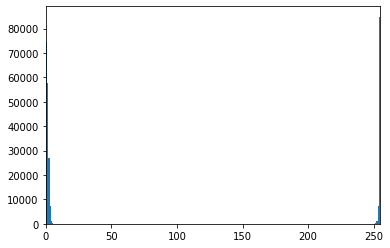

In [ ]:
diff_image = get_differential_image (imageArray, cimageArray, show_hist=True, show_image=False)

In [ ]:
local_df = get_metrics(image_name, coder, imageArray, cimageArray, cr, compression_parameter, original_image=False)
local_df.head()

,image,coder,mse,psnr,mse_hvs,psnrhvs,mse_hvs_m,psnrhvsm,compression_ratio,msssim,compression_parameter,original
0,goldhill.bmp,AGU,17.675323,35.65713,23.958057,34.336288,8.295016,38.942631,10.313727,0.988642,20.0,False


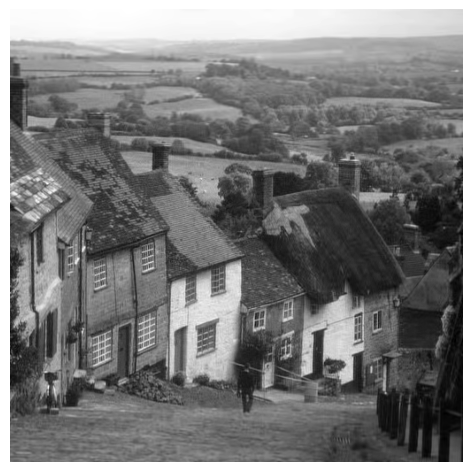

In [ ]:
plot_numpy2D(cimageArray, pedestal=0)

### Example Loop

In [ ]:
coders = ['AGU', 'BPG', 'JPEG2000']  # BPG, AGU, ADCT, AGUm, ADCTm, JPEG, JPEG2000
compression_parameters = np.arange(30, 35, 1)  # QS, Q etc.
noise_std = 0  # noise StD, uint8
path_to_images = os.path.join(path_to_root_folder, 'Images').replace(" ", "")
filenames = [ f for f in os.listdir(path_to_images) if os.path.isfile(os.path.join(path_to_images, f))]
print(filenames)


['BABOON.BMP', 'BARBARA.BMP', 'aerial.bmp', 'airfield.bmp', 'frisco.bmp', 'fr01.bmp', 'fr02.bmp', 'fr03.bmp', 'fr04.bmp', 'DIEGO.BMP', 'mrt_prepared.bmp', 'goldhill.bmp', 'lenna.bmp']
hello


In [ ]:
df = None
for coder in coders:
  for filename in filenames:
    print(f'Coder: {coder}, image: {filename}')
    for compression_parameter in tqdm(compression_parameters):
      imageArray, cimageArray, cr = get_compressed_image_II(path_to_root_folder, 'Images', filename, coder, compression_parameter)      
      local_df = get_metrics(filename, coder, imageArray, cimageArray, cr, compression_parameter, original_image=False)
      if df is None:
        df = local_df
      else:
        df = df.append(local_df, ignore_index = True)

# save results to CSV and XLS (folder Results)
df.to_csv(os.path.join(os.path.join(path_to_root_folder, 'Results'), 'result.csv').replace(" ", ""), index=False)
df.to_excel(os.path.join(os.path.join(path_to_root_folder, 'Results'), 'result.xlsx').replace(" ", ""), sheet_name=','.join(coders))

Coder: AGU, image: BABOON.BMP


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: BARBARA.BMP


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: aerial.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: airfield.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: frisco.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: fr01.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: fr02.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: fr03.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: fr04.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: DIEGO.BMP


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: mrt_prepared.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: goldhill.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: AGU, image: lenna.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: BABOON.BMP


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: BARBARA.BMP


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: aerial.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: airfield.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: frisco.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: fr01.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: fr02.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: fr03.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: fr04.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: DIEGO.BMP


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: mrt_prepared.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: goldhill.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: BPG, image: lenna.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: BABOON.BMP


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: BARBARA.BMP


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: aerial.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: airfield.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: frisco.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: fr01.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: fr02.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: fr03.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: fr04.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: DIEGO.BMP


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: mrt_prepared.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: goldhill.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

Coder: JPEG2000, image: lenna.bmp


  0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
df.head(20)

,image,coder,mse,psnr,mse_hvs,psnrhvs,mse_hvs_m,psnrhvsm,compression_ratio,msssim,compression_parameter,original
0,BABOON.BMP,AGU,51.017662,31.053598,62.399160,30.179016,18.920386,35.361504,6.558519,0.983113,30.0,False
1,BABOON.BMP,AGU,53.614761,30.837960,66.039232,29.932783,20.505153,35.012173,6.757334,0.982192,31.0,False
2,BABOON.BMP,AGU,56.318642,30.624282,69.716444,29.697451,22.105989,34.685704,6.970617,0.981283,32.0,False
3,BABOON.BMP,AGU,58.944855,30.426345,73.838611,29.447968,24.065293,34.316892,7.170829,0.980341,33.0,False
4,BABOON.BMP,AGU,61.641102,30.232100,77.650942,29.229336,25.725821,34.027111,7.384338,0.979448,34.0,False
5,BARBARA.BMP,AGU,21.241993,34.858851,36.463533,32.512216,14.672421,36.465786,15.473026,0.987089,30.0,False
6,BARBARA.BMP,AGU,22.139774,34.679072,38.312437,32.297406,15.698432,36.172241,15.918387,0.986503,31.0,False
7,BARBARA.BMP,AGU,23.050919,34.503921,40.417170,32.065145,16.746292,35.891617,16.363546,0.986050,32.0,False
8,BARBARA.BMP,AGU,23.959999,34.335936,42.120462,31.885872,17.711877,35.648158,16.837562,0.985521,33.0,False
9,BARBARA.BMP,AGU,24.938736,34.162059,44.256237,31.671059,18.929968,35.359305,17.314663,0.984987,34.0,False


In [ ]:
#plot_scatter_1csv(os.path.join(os.path.join(path_to_root_folder, 'Results'), 'result.csv').replace(" ", ""), 'compression_parameter', 'psnrhvsm', 'goldhill.bmp')

### Calculate PSNR-HVS-M and CR for BPG, Q=24-30, dental images

In [23]:
coders = ['BPG']  # BPG, AGU, ADCT, AGUm, ADCTm, JPEG, JPEG2000
compression_parameters = np.arange(24, 30, 1)  # QS, Q etc.
path_to_images = os.path.join(path_to_root_folder, 'Dental_panorama_chunks_child').replace(" ", "")
filenames = [ f for f in os.listdir(path_to_images) if os.path.isfile(os.path.join(path_to_images, f))]
print(filenames)

['01439_Panorama_20220124131235_10.png', '01439_Panorama_20220124131235_00.png', '01439_Panorama_20220124131235_13.png', '01439_Panorama_20220124131235_11.png', '01439_Panorama_20220124131235_12.png', '01439_Panorama_20220124131235_03.png', '01439_Panorama_20220124131235_01.png', '01439_Panorama_20220124131235_02.png']


In [24]:
df = None
for coder in coders:
  for filename in filenames:
    print(f'Coder: {coder}, image: {filename}')
    for compression_parameter in tqdm(compression_parameters):      
      imageArray, cimageArray, cr = get_compressed_image_II(path_to_root_folder, 'Dental_panorama_chunks_child', filename, coder, compression_parameter)      
      local_df = get_metrics(filename, coder, imageArray, cimageArray, cr, compression_parameter, original_image=False)
      if df is None:
        df = local_df
      else:
        df = df.append(local_df, ignore_index = True)

# save results to CSV and XLS (folder Results)
df.to_csv(os.path.join(os.path.join(path_to_root_folder, 'Results'), 'result_child.csv').replace(" ", ""), index=False)
df.to_excel(os.path.join(os.path.join(path_to_root_folder, 'Results'), 'result_child.xlsx').replace(" ", ""), sheet_name=','.join(coders))

Coder: BPG, image: 01439_Panorama_20220124131235_10.png


  0%|          | 0/6 [00:00<?, ?it/s]

Coder: BPG, image: 01439_Panorama_20220124131235_00.png


  0%|          | 0/6 [00:00<?, ?it/s]

Coder: BPG, image: 01439_Panorama_20220124131235_13.png


  0%|          | 0/6 [00:00<?, ?it/s]

Coder: BPG, image: 01439_Panorama_20220124131235_11.png


  0%|          | 0/6 [00:00<?, ?it/s]

Coder: BPG, image: 01439_Panorama_20220124131235_12.png


  0%|          | 0/6 [00:00<?, ?it/s]

Coder: BPG, image: 01439_Panorama_20220124131235_03.png


  0%|          | 0/6 [00:00<?, ?it/s]

Coder: BPG, image: 01439_Panorama_20220124131235_01.png


  0%|          | 0/6 [00:00<?, ?it/s]

Coder: BPG, image: 01439_Panorama_20220124131235_02.png


  0%|          | 0/6 [00:00<?, ?it/s]

In [25]:
def plot_scatter_all_images(df_Q, Xname, Yname):
    """
    Plot scatter for all images

    Args:        
        df_Q: target dataframe
        Xname: X axis parameter name according to name in DataFrame
        Yname: Y axis parameter name according to name in DataFrame        

    Returns:

    """       
    matplotlib.rcParams.update({'font.size': 19})
    plt.scatter(df_Q[Xname], df_Q[Yname], c="r", marker='x')
    plt.xlabel(Xname)
    plt.ylabel(Yname)  
    plt.legend(loc='best', fontsize='small', labels=['BPG'])
    plt.title('{0} = f({1}), Q = {2}'.format(Yname, Xname, df_Q.loc[0, 'compression_parameter']))
    plt.grid()
    plt.savefig(os.path.join(os.path.join(path_to_root_folder, 'Results'), 'psnrhvsm_cr_Q' + str(int(df_Q.loc[0, 'compression_parameter'])) + '.png').replace(" ", ""))
    plt.show()

-----


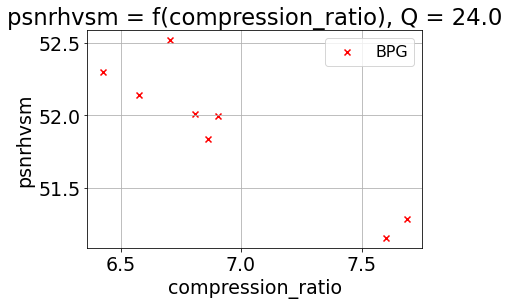

-----


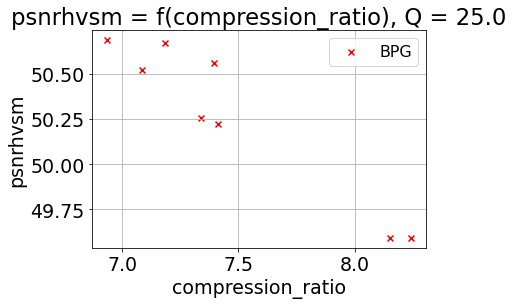

-----


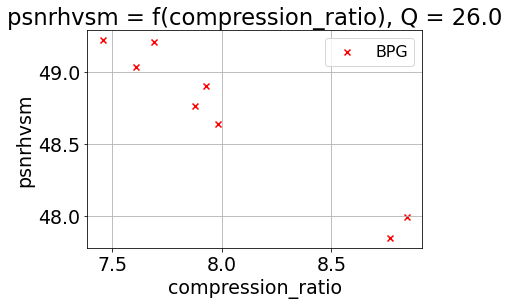

-----


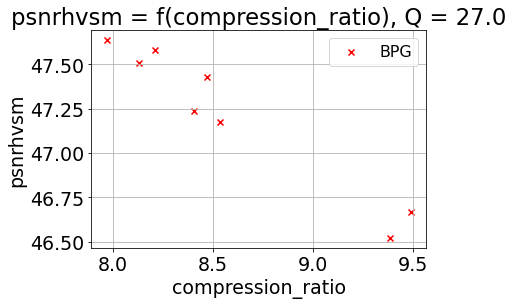

-----


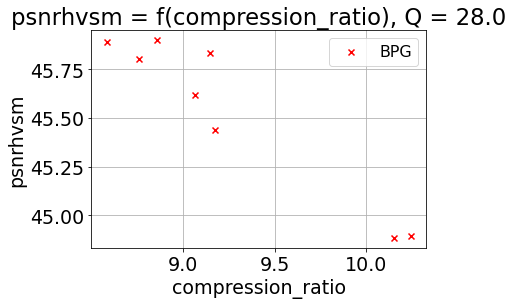

-----


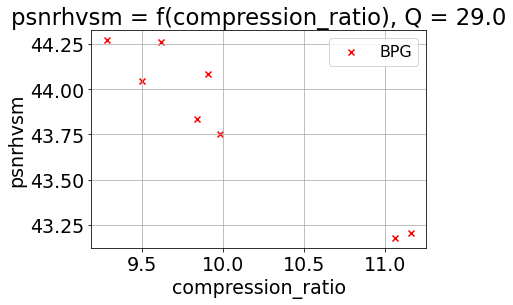

In [29]:
df_csv = pd.read_csv(os.path.join(os.path.join(path_to_root_folder, 'Results'), 'result_child.csv').replace(" ", ""))
Q_steps = [24, 25, 26, 27, 28, 29]
Xname = 'compression_ratio'
Yname = 'psnrhvsm'
for Q in Q_steps:
  print('-----')
  df_Q = df_csv[(df_csv['compression_parameter']==Q)].reset_index(drop=True)
  plot_scatter_all_images(df_Q, Xname, Yname)
